In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imu-data-1/IMU_concat2.txt
/kaggle/input/imu-data-1/filter_excel/01--3_split.xlsx
/kaggle/input/imu-data-1/filter_excel/02--3_split.xlsx
/kaggle/input/imu-data-1/filter_excel/01--2_split.xlsx
/kaggle/input/imu-data-1/filter_excel/04--2_split.xlsx
/kaggle/input/imu-data-1/filter_excel/03--2_split.xlsx
/kaggle/input/imu-data-1/filter_excel/02--2_split.xlsx
/kaggle/input/imu-data-1/filter_excel/04--1_split.xlsx
/kaggle/input/imu-data-1/filter_excel/01--1_split.xlsx
/kaggle/input/imu-data-1/filter_excel/03--3_split.xlsx
/kaggle/input/imu-data-1/filter_excel/02--1_split.xlsx
/kaggle/input/imu-data-1/filter_excel/03--1_split.xlsx
/kaggle/input/imu-data-1/filter_excel/04--3_split.xlsx
/kaggle/input/0702data-02/tag_concat/02-LegCurl-30-1-segment4.csv
/kaggle/input/0702data-02/tag_concat/02-Lunge-50-2-segment5.csv
/kaggle/input/0702data-02/tag_concat/02-Squat-30-3-segment5.csv
/kaggle/input/0702data-02/tag_concat/02-Squat-50-3-segment4.csv
/kaggle/input/0702data-02/tag_concat/02-L

In [2]:
!pip install torchmetrics

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy
from tqdm import tqdm

%matplotlib inline

import glob
import random
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fnmatch import fnmatch, fnmatchcase
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from math import sqrt
import os
import math
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report

# plt.rcParams['font.sans-serif']=['STSong']
# plt.rcParams['figure.figsize'] = [5, 1]
# plt.rcParams["figure.dpi"] = 400 # 设置分辨率

In [66]:
# 定义随机种子固定的函数
def get_random_seed(seed):
    random.seed(seed)
    # 禁止 hash 随机化
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # 设置当前 CPU 的随机种子
    torch.manual_seed(seed)
    # 设置当前 GPU 的随机种子
    torch.cuda.manual_seed(seed)
    # 确定是否使用确定性卷积算法（默认是 False ），如果为 True，则能保证在相同设备上的相同输入能够实现相同输出
    torch.backends.cudnn.deterministic = True
    # 如果设置 torch.backends.cudnn.benchmark = True 会让程序在一开始时增加额外的预处理时间，
    # 以让整个 model 的卷积层寻找到最适合的、最有效率的卷积实现算法，进而实现网络加速，
    # 但是与此同时可能会导致结果不可复现
    torch.backends.cudnn.benchmark = False
    
# 调用函数，设置随机种子为66
get_random_seed(66)

In [135]:
df = pd.read_csv(r'/kaggle/input/imu-data-1/IMU_concat2.txt', sep='\t', header = 0)

df.shape

(1352580, 8)

In [4]:
df.head(3)

,A-x,A-y,A-z,W-x,W-y,W-z,user,type
0,-0.3320,1.1172,0.1133,-2.8099,-1.6406,0.5236,1,up stairs
1,-0.1016,0.9063,-0.1094,-2.7925,-2.1118,0.6632,1,up stairs
2,0.1328,0.8359,-0.1133,-2.5132,-2.5656,0.6981,1,up stairs


In [105]:
# 0612 data
flag = False
filepath_list = list()
# root_tag = r'/kaggle/input/0612-amplitude-raw-tag/segments_amplitude_raw_tag'
root_tag = r'/kaggle/input/0702data-02'
lenth = 0
count = 0

for dirpath, dirnames, filenames in os.walk(root_tag):
    # print(filenames)
    for filepath in filenames:
        if fnmatch(filepath, '*.csv'):
            count += 1
            filepath_list.append(os.path.join(dirpath, filepath))

            df = pd.read_csv(os.path.join(dirpath, filepath), header=0)

            if flag:
                d_new = pd.concat([d_new, df], axis=0, ignore_index=True, join="inner")
            else:
                d_new = df.copy()
                flag = True
                length = len(df)

df = d_new

df.shape, length, count, df.shape[0]/length

((168012, 21), 468, 359, 359.0)

In [106]:
df.head(3)

,02-A-x,02-A-y,02-A-z,03-A-x,03-A-y,03-A-z,05-A-x,05-A-y,05-A-z,06-A-x,...,06-A-z,02-A-amplitude,03-A-amplitude,05-A-amplitude,06-A-amplitude,user_id,activity,extent,num_group,num_seg
0,-0.007800,0.976600,-0.199200,0.070300,0.972700,-0.171900,-0.074200,0.980500,-0.089800,-0.128900,...,-0.140600,0.016739,0.010271,0.007396,0.007399,2,LegCurl,30,1,4
1,-0.004259,0.973486,-0.194476,0.076122,0.973977,-0.172935,-0.074058,0.981314,-0.091501,-0.129360,...,-0.141985,0.012730,0.012116,0.008350,0.003574,2,LegCurl,30,1,4
2,-0.004004,0.972589,-0.196170,0.084447,0.971886,-0.171208,-0.074537,0.979718,-0.095211,-0.128498,...,-0.139732,0.012185,0.010462,0.007150,0.003837,2,LegCurl,30,1,4


In [107]:
for label in df.columns:
    if fnmatch(label, '02-A*') or fnmatch(label, '03-A*') or fnmatch(label, '06-A*'):
        df.drop(labels=label, axis=1, inplace=True)
        
df.head(3)

,05-A-x,05-A-y,05-A-z,05-A-amplitude,user_id,activity,extent,num_group,num_seg
0,-0.074200,0.980500,-0.089800,0.007396,2,LegCurl,30,1,4
1,-0.074058,0.981314,-0.091501,0.008350,2,LegCurl,30,1,4
2,-0.074537,0.979718,-0.095211,0.007150,2,LegCurl,30,1,4


In [70]:
for label in df.columns[6:8]:
        df.drop(labels=label, axis=1, inplace=True)
        
df.head(3)

,05-A-x,05-A-y,05-A-z,06-A-x,06-A-y,06-A-z,user_id,activity,extent,num_group,num_seg
0,-0.074200,0.980500,-0.089800,-0.128900,0.968800,-0.140600,2,LegCurl,30,1,4
1,-0.074058,0.981314,-0.091501,-0.129360,0.964641,-0.141985,2,LegCurl,30,1,4
2,-0.074537,0.979718,-0.095211,-0.128498,0.965347,-0.139732,2,LegCurl,30,1,4


In [108]:
df.head(3)

,05-A-x,05-A-y,05-A-z,05-A-amplitude,user_id,activity,extent,num_group,num_seg
0,-0.074200,0.980500,-0.089800,0.007396,2,LegCurl,30,1,4
1,-0.074058,0.981314,-0.091501,0.008350,2,LegCurl,30,1,4
2,-0.074537,0.979718,-0.095211,0.007150,2,LegCurl,30,1,4


In [109]:
df.activity.unique(), df.extent.unique()

(array(['LegCurl', 'Lunge', 'Squat'], dtype=object), array([30, 50, 70, 90]))

In [110]:
level_list = {30: 'S', 50: 'M', 70: 'L', 90: 'H'}

for index, value in enumerate(df.extent.values):
    df.activity.values[index] += level_list[value]
    
df.activity.unique(), len(df.activity.unique())

(array(['LegCurlS', 'LungeM', 'SquatS', 'SquatM', 'LungeL', 'SquatL',
        'SquatH', 'LegCurlH', 'LungeS', 'LungeH', 'LegCurlM', 'LegCurlL'],
       dtype=object),
 12)

In [111]:
# df = df.loc[df.activity=='Squat'].copy()
# df['activity'] = df.activity + df.level
# label_list = {'SquatL': 0, 'SquatM': 1, 'SquatH': 2, 'LunL': 3, 'LunM': 4, 'LunH': 5}
label_list = {'LegCurlS': 0, 'LegCurlM': 1, 'LegCurlL': 2, 'LegCurlH': 3,
              'LungeS': 4,'LungeM': 5, 'LungeL': 6, 'LungeH': 7,
              'SquatS': 8, 'SquatM': 9,  'SquatL': 10,'SquatH': 11}

# label_list = {'L': 0, 'M': 1, 'H': 2}
# label_list = {'Squat': 0, 'Lun': 1}
 
for index, value in enumerate(df['activity'].values):
    df['activity'].values[index] = label_list[value]
    
df.drop(labels='user_id', axis=1, inplace=True)
df.drop(labels='extent', axis=1, inplace=True)
df.drop(labels='num_group', axis=1, inplace=True)

df_train = df.iloc[df['num_seg'].values <= 7].copy()
df_test = df.iloc[df['num_seg'].values > 7].copy()

df_train.drop(labels='num_seg', axis=1, inplace=True)
df_test.drop(labels='num_seg', axis=1, inplace=True)

y_train = df_train['activity']
y_test = df_test['activity']

df_train.shape, df_test.shape, label_list

((117936, 5),
 (50076, 5),
 {'LegCurlS': 0,
  'LegCurlM': 1,
  'LegCurlL': 2,
  'LegCurlH': 3,
  'LungeS': 4,
  'LungeM': 5,
  'LungeL': 6,
  'LungeH': 7,
  'SquatS': 8,
  'SquatM': 9,
  'SquatL': 10,
  'SquatH': 11})

In [112]:
df_train.head(3)

,05-A-x,05-A-y,05-A-z,05-A-amplitude,activity
0,-0.074200,0.980500,-0.089800,0.007396,0
1,-0.074058,0.981314,-0.091501,0.008350,0
2,-0.074537,0.979718,-0.095211,0.007150,0


In [113]:
df_test.head(3)

,05-A-x,05-A-y,05-A-z,05-A-amplitude,activity
2340,-0.050800,0.976600,-0.113300,0.004462,0
2341,-0.046719,0.978485,-0.108227,0.005555,0
2342,-0.047942,0.982503,-0.111860,0.010019,0


In [77]:
df_train.activity.unique(), df_test.activity.unique()

(array([0, 5, 8, 9, 6, 10, 11, 3, 4, 1, 7, 2], dtype=object),
 array([0, 6, 7, 1, 3, 11, 9, 10, 8, 4, 2, 5], dtype=object))

In [14]:
df_train.shape[0]/length, df_test.shape[0]/length, df_train.shape[0]/length + df_test.shape[0]/length

(252.0, 107.0, 359.0)

In [114]:
from scipy import stats

def segments(df, frame_length, hop_length, label_name):
    N_FEATURES = 4
    segments = []
    labels = []
    for i in range(0, len(df), hop_length):
#         ax1 = df['02-A-x'].values[i:i+frame_length]
#         ay1 = df['02-A-y'].values[i:i+frame_length]
#         az1 = df['02-A-z'].values[i:i+frame_length]
        
#         ax2 = df['03-A-x'].values[i:i+frame_length]
#         ay2 = df['03-A-y'].values[i:i+frame_length]
#         az2 = df['03-A-z'].values[i:i+frame_length]
        
        ax3 = df['05-A-x'].values[i:i+frame_length]
        ay3 = df['05-A-y'].values[i:i+frame_length]
        az3 = df['05-A-z'].values[i:i+frame_length]

#         ax4 = df['06-A-x'].values[i:i+frame_length]
#         ay4 = df['06-A-y'].values[i:i+frame_length]
#         az4 = df['06-A-z'].values[i:i+frame_length]
        
#         am1 = df['02-A-amplitude'].values[i:i+frame_length]
#         am2 = df['03-A-amplitude'].values[i:i+frame_length]
        am3 = df['05-A-amplitude'].values[i:i+frame_length]
#         am4 = df['06-A-amplitude'].values[i:i+frame_length]
        
        label = stats.mode(df[label_name][i:i+frame_length])[0][0]
        segments.append([ax3, ay3, az3, am3])
#         segments.append([ax3, ay3, az3, ax4, ay4, az4])
#         segments.append([am3, am4])
#         segments.append([ax1, ay1, az1, ax2, ay2, az2, ax3, ay3, az3, ax4, ay4, az4, am1, am2, am3, am4])
#         segments.append([ax3, ay3, az3, ax4, ay4, az4, am3, am4])

        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, frame_length, N_FEATURES)
    labels = np.asarray(labels)
    
    print("segments shape:{}".format(np.shape(segments)))
    
    return reshaped_segments, labels

frame_length = length
hop_length = length
LABEL = 'activity'
X_train, y_train = segments(df_train, frame_length, hop_length, LABEL)
X_test, y_test = segments(df_test, frame_length, hop_length, LABEL)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

segments shape:(252, 4, 468)
segments shape:(107, 4, 468)


((252, 468, 4), (252,), (107, 468, 4), (107,))

In [136]:
import numpy as np
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
df = df.sort_values(by = ['user'], ignore_index=True)
df['type'] = label_encoder.fit_transform(df.type)

df_train ,df_test = train_test_split(df, test_size=0.3, random_state=16)
# df_train = df.iloc[df['user'].values < 4]
# df_test = df.iloc[df['user'].values == 4]

# y_train = label_encoder.fit_transform(df_train.type)
# y_test = label_encoder.fit_transform(df_test.type)

df_train.shape, df_test.shape

((946806, 8), (405774, 8))

In [16]:
X_train.shape, X_test.shape, X_train.shape[0] + X_test.shape[0]

((252, 468, 8), (107, 468, 8), 359)

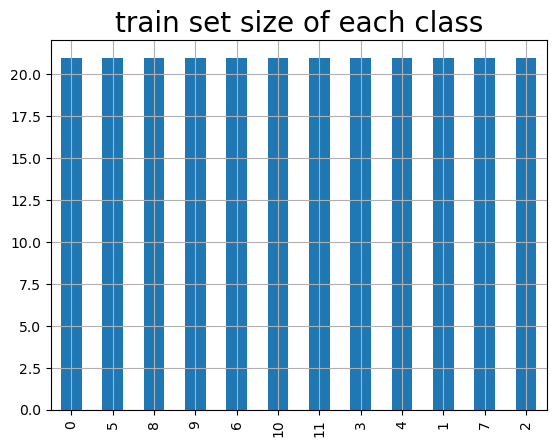

0     21.0
5     21.0
8     21.0
9     21.0
6     21.0
10    21.0
11    21.0
3     21.0
4     21.0
1     21.0
7     21.0
2     21.0
Name: activity, dtype: float64


In [16]:
# train activities
activity_stats = df_train.activity.value_counts()/length
activities = activity_stats.index.tolist()
activity_stats.plot(kind='bar')
plt.title('train set size of each class', fontsize=20)
plt.grid()
plt.show()
print(activity_stats)

In [27]:
21*11 + 9*11 -1

329

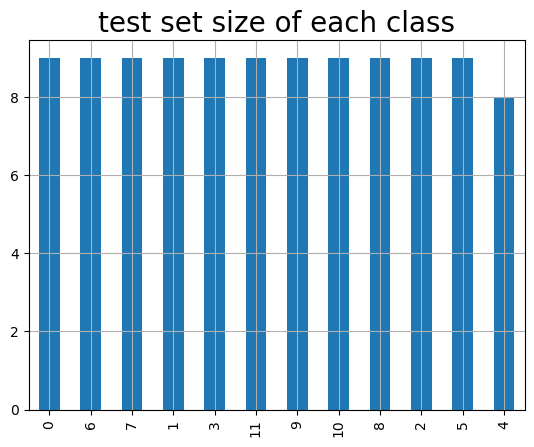

0     9
6     9
7     9
1     9
3     9
11    9
9     9
10    9
8     9
2     9
5     9
4     8
Name: activity, dtype: int64


In [17]:
# eval activities
activity_stats = df_test.activity.value_counts()//length
activities = activity_stats.index.tolist()
activity_stats.plot(kind='bar')
plt.title('test set size of each class', fontsize=20)
plt.grid()
plt.show()
print(activity_stats)

In [80]:
type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [115]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((252, 468, 4), (252,), (107, 468, 4), (107,))

In [116]:
#convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([252, 468, 4]),
 torch.Size([252]),
 torch.Size([107, 468, 4]),
 torch.Size([107]))

In [10]:
X_train = X_train.permute(1, 0, 2)
X_test = X_test.permute(1, 0, 2)
# y_train = y_train.permute(1, 0)
# y_test = y_test.permute(1, 0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([946806, 1, 6]),
 torch.Size([946806]),
 torch.Size([405774, 1, 6]),
 torch.Size([405774]))

In [117]:
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, drop_last=True)

#check shapes
for x, y in train_loader:
    print(x.shape, y.shape)
    break
    
for x, y in test_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 468, 4]) torch.Size([32])
torch.Size([32, 468, 4]) torch.Size([32])


In [69]:
# y_test.shape, y_test.softmax(dim=1).shape
torch.max(y_train, 1)[0].shape

torch.Size([96])

In [118]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [119]:
from sklearn.metrics import confusion_matrix

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  # model.train()，作用是 启用 batch normalization 和 dropout
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=12).to(device)   #task='multiclass', num_classes=6
 
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
        
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
        
      inputs = inputs.to(device)
      targets = targets.to(device)

      # 前向传播
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      # 反向传播和优化
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, accuracy=acc_train.compute().item())
        
  return model, loss_train.avg, acc_train.compute().item()

def validation(model, test_loader, loss_fn, best_cm, best_acc, cm, y_labels, best_preds):
  all_preds = []
  all_labels = []

  # model.eval()的作用是 不启用 Batch Normalization 和 Dropout
  model.eval()

  with torch.no_grad():
    
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=12).to(device)

    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      # 前向传播
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())

      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(targets.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    # 计算准确率
    acc = np.trace(cm) / np.sum(cm)
    # 如果当前准确率超过之前最佳准确率，则更新最佳准确率和混淆矩阵
    if acc >= best_acc:
      best_acc = acc
      best_cm = cm
      y_labels = all_labels
      best_preds = all_preds
  
  return loss_valid.avg, acc_valid.compute().item(), best_acc, best_cm, cm, y_labels, best_preds

In [136]:
class CNNLSTM(nn.Module):
  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, num_cls):
    super().__init__()
    
    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=5, stride=5)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)
#     self.pool1 = nn.AdaptiveAvgPool1d(2)
    
    self.conv2 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=5, stride=5)
    self.bn2 = nn.BatchNorm1d(cnn_hidden_size)
#     self.pool2 = nn.AdaptiveAvgPool1d(3)
    
#     self.conv3 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=3, padding=1, dilation=1)
#     self.bn3 = nn.BatchNorm1d(cnn_hidden_size)
    
    self.pool = nn.AdaptiveAvgPool1d(3)
    
#     self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers, batch_first=True)
    self.hidden_size = rnn_hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(cnn_hidden_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(self.hidden_size * 2, num_cls)

#     self.fc = nn.Linear(rnn_hidden_size, num_cls)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()
#     y = self.pool1(y)
    y = self.bn2(self.conv2(y)).relu()
#     y = self.pool2(y)
#     y = self.bn3(self.conv3(y)).relu()
    y = self.pool(y)
    
    y = y.permute(0, 2, 1)
#     y, _ = self.lstm(y)
#     y = self.fc(y)
    h0 = torch.zeros(self.num_layers * 2, y.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers * 2, y.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(y)
    out = self.fc(out[:, -1, :])
#     out = self.fc()
#     return y.mean(dim=1)
    return out

In [137]:
model = CNNLSTM(4, 64, 128, 1, 12).to(device)
model

CNNLSTM(
  (conv1): Conv1d(4, 64, kernel_size=(5,), stride=(5,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(5,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool1d(output_size=3)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=12, bias=True)
)

In [131]:
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.05):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        # 此处的self.smoothing即我们的epsilon平滑参数。

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [138]:
lr = 0.01
wd = 1e-4

# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# loss_fn = nn.CrossEntropyLoss()
loss_fn = LabelSmoothing()

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

now = datetime.datetime.now()
timestamp = datetime.datetime.timestamp(now)
date_time = datetime.datetime.fromtimestamp(timestamp)
formatted_date_time = date_time.strftime("%Y-%m-%d %H:%M:%S")

In [139]:
num_epochs = 300
cm = None
best_cm = None
best_acc = 0.0
y_labels = []
best_preds = []

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid, best_acc, best_cm, cm, y_labels, best_preds = validation(model,
                                     test_loader,
                                     loss_fn, best_cm, best_acc, cm, y_labels, best_preds)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), \
                  'epoch': epoch}
    torch.save(checkpoint , f'model.pt')
#     torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 87.54batch/s, accuracy=0.107, loss=2.48]


Valid: Loss = 2.483, Acc = 0.08333



Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 91.18batch/s, accuracy=0.161, loss=2.46]


Valid: Loss = 2.482, Acc = 0.08333



Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 87.63batch/s, accuracy=0.165, loss=2.44]


Valid: Loss = 2.48, Acc = 0.08333



Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 86.68batch/s, accuracy=0.138, loss=2.41]


Valid: Loss = 2.473, Acc = 0.1042



Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 91.10batch/s, accuracy=0.129, loss=2.38]


Valid: Loss = 2.457, Acc = 0.2292



Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 88.57batch/s, accuracy=0.232, loss=2.32]


Valid: Loss = 2.423, Acc = 0.2396



Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 91.81batch/s, accuracy=0.268, loss=2.26]


Valid: Loss = 2.353, Acc = 0.2812



Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 95.70batch/s, accuracy=0.286, loss=2.2]


Valid: Loss = 2.259, Acc = 0.2708



Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 90.84batch/s, accuracy=0.254, loss=2.14]


Valid: Loss = 2.141, Acc = 0.3333



Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 89.25batch/s, accuracy=0.388, loss=2.05]


Valid: Loss = 2.046, Acc = 0.4688



Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 90.33batch/s, accuracy=0.438, loss=1.98]


Valid: Loss = 1.946, Acc = 0.5



Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 94.43batch/s, accuracy=0.424, loss=1.92]


Valid: Loss = 1.881, Acc = 0.5104



Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 92.00batch/s, accuracy=0.433, loss=1.85]


Valid: Loss = 1.812, Acc = 0.5521



Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 91.81batch/s, accuracy=0.571, loss=1.79]


Valid: Loss = 1.756, Acc = 0.5833



Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 88.95batch/s, accuracy=0.621, loss=1.71]


Valid: Loss = 1.696, Acc = 0.625



Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 99.11batch/s, accuracy=0.754, loss=1.62]

Valid: Loss = 1.625, Acc = 0.6771

Epoch 16: 100%|██████████| 7/7 [00:00<00:00, 90.48batch/s, accuracy=0.737, loss=1.58]

Valid: Loss = 1.563, Acc = 0.75




Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 92.43batch/s, accuracy=0.71, loss=1.5]


Valid: Loss = 1.539, Acc = 0.6667



Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 87.77batch/s, accuracy=0.763, loss=1.42]


Valid: Loss = 1.428, Acc = 0.7083



Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 61.08batch/s, accuracy=0.772, loss=1.32]


Valid: Loss = 1.35, Acc = 0.7292



Epoch 20: 100%|██████████| 7/7 [00:00<00:00, 54.39batch/s, accuracy=0.772, loss=1.29]


Valid: Loss = 1.3, Acc = 0.7604



Epoch 21: 100%|██████████| 7/7 [00:00<00:00, 97.20batch/s, accuracy=0.804, loss=1.2]


Valid: Loss = 1.226, Acc = 0.7708



Epoch 22: 100%|██████████| 7/7 [00:00<00:00, 91.29batch/s, accuracy=0.799, loss=1.17]

Valid: Loss = 1.166, Acc = 0.8229




Epoch 23: 100%|██████████| 7/7 [00:00<00:00, 90.05batch/s, accuracy=0.862, loss=1.11]


Valid: Loss = 1.117, Acc = 0.8542



Epoch 24: 100%|██████████| 7/7 [00:00<00:00, 88.52batch/s, accuracy=0.839, loss=1.08]


Valid: Loss = 1.088, Acc = 0.8125



Epoch 25: 100%|██████████| 7/7 [00:00<00:00, 92.26batch/s, accuracy=0.839, loss=1.04]


Valid: Loss = 1.049, Acc = 0.875



Epoch 26: 100%|██████████| 7/7 [00:00<00:00, 91.26batch/s, accuracy=0.938, loss=0.976]


Valid: Loss = 1.001, Acc = 0.9167



Epoch 27: 100%|██████████| 7/7 [00:00<00:00, 87.04batch/s, accuracy=0.906, loss=0.948]


Valid: Loss = 0.9705, Acc = 0.8958



Epoch 28: 100%|██████████| 7/7 [00:00<00:00, 89.94batch/s, accuracy=0.929, loss=0.921]


Valid: Loss = 0.9432, Acc = 0.8854



Epoch 29: 100%|██████████| 7/7 [00:00<00:00, 91.97batch/s, accuracy=0.879, loss=0.908]


Valid: Loss = 0.9104, Acc = 0.8958



Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 88.09batch/s, accuracy=0.933, loss=0.861]


Valid: Loss = 0.8814, Acc = 0.9271



Epoch 31: 100%|██████████| 7/7 [00:00<00:00, 90.25batch/s, accuracy=0.933, loss=0.817]


Valid: Loss = 0.8649, Acc = 0.9062



Epoch 32: 100%|██████████| 7/7 [00:00<00:00, 88.52batch/s, accuracy=0.942, loss=0.797]


Valid: Loss = 0.8356, Acc = 0.9062



Epoch 33: 100%|██████████| 7/7 [00:00<00:00, 88.65batch/s, accuracy=0.929, loss=0.789]


Valid: Loss = 0.8247, Acc = 0.8854



Epoch 34: 100%|██████████| 7/7 [00:00<00:00, 87.60batch/s, accuracy=0.955, loss=0.731]


Valid: Loss = 0.801, Acc = 0.9062



Epoch 35: 100%|██████████| 7/7 [00:00<00:00, 88.62batch/s, accuracy=0.951, loss=0.729]


Valid: Loss = 0.7966, Acc = 0.8854



Epoch 36: 100%|██████████| 7/7 [00:00<00:00, 89.47batch/s, accuracy=0.964, loss=0.678]


Valid: Loss = 0.7835, Acc = 0.8333



Epoch 37: 100%|██████████| 7/7 [00:00<00:00, 96.20batch/s, accuracy=0.955, loss=0.695]


Valid: Loss = 0.7403, Acc = 0.9375



Epoch 38: 100%|██████████| 7/7 [00:00<00:00, 89.75batch/s, accuracy=0.969, loss=0.652]


Valid: Loss = 0.7381, Acc = 0.8958



Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 91.44batch/s, accuracy=0.973, loss=0.638]


Valid: Loss = 0.7148, Acc = 0.9167



Epoch 40: 100%|██████████| 7/7 [00:00<00:00, 88.08batch/s, accuracy=0.955, loss=0.624]


Valid: Loss = 0.7024, Acc = 0.8854



Epoch 41: 100%|██████████| 7/7 [00:00<00:00, 87.12batch/s, accuracy=0.969, loss=0.6]


Valid: Loss = 0.6945, Acc = 0.8958



Epoch 42: 100%|██████████| 7/7 [00:00<00:00, 88.66batch/s, accuracy=0.96, loss=0.615]


Valid: Loss = 0.6937, Acc = 0.9062



Epoch 43: 100%|██████████| 7/7 [00:00<00:00, 90.63batch/s, accuracy=0.978, loss=0.576]


Valid: Loss = 0.6908, Acc = 0.8854



Epoch 44: 100%|██████████| 7/7 [00:00<00:00, 88.03batch/s, accuracy=0.982, loss=0.571]


Valid: Loss = 0.6669, Acc = 0.8958



Epoch 45: 100%|██████████| 7/7 [00:00<00:00, 88.82batch/s, accuracy=0.969, loss=0.557]


Valid: Loss = 0.6581, Acc = 0.8854



Epoch 46: 100%|██████████| 7/7 [00:00<00:00, 84.06batch/s, accuracy=0.978, loss=0.555]


Valid: Loss = 0.6276, Acc = 0.9271



Epoch 47: 100%|██████████| 7/7 [00:00<00:00, 85.70batch/s, accuracy=0.991, loss=0.545]


Valid: Loss = 0.6337, Acc = 0.9167



Epoch 48: 100%|██████████| 7/7 [00:00<00:00, 86.27batch/s, accuracy=0.964, loss=0.554]


Valid: Loss = 0.6213, Acc = 0.9271



Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 81.73batch/s, accuracy=0.978, loss=0.533]


Valid: Loss = 0.6232, Acc = 0.9167



Epoch 50: 100%|██████████| 7/7 [00:00<00:00, 85.74batch/s, accuracy=0.982, loss=0.516]


Valid: Loss = 0.6093, Acc = 0.9271



Epoch 51: 100%|██████████| 7/7 [00:00<00:00, 92.62batch/s, accuracy=0.991, loss=0.501]


Valid: Loss = 0.6303, Acc = 0.8958



Epoch 52: 100%|██████████| 7/7 [00:00<00:00, 89.11batch/s, accuracy=0.964, loss=0.525]


Valid: Loss = 0.6177, Acc = 0.9271



Epoch 53: 100%|██████████| 7/7 [00:00<00:00, 88.35batch/s, accuracy=0.96, loss=0.523]


Valid: Loss = 0.6117, Acc = 0.8958



Epoch 54: 100%|██████████| 7/7 [00:00<00:00, 90.31batch/s, accuracy=0.978, loss=0.483]


Valid: Loss = 0.6302, Acc = 0.8958



Epoch 55: 100%|██████████| 7/7 [00:00<00:00, 83.92batch/s, accuracy=0.996, loss=0.474]


Valid: Loss = 0.6022, Acc = 0.9271



Epoch 56: 100%|██████████| 7/7 [00:00<00:00, 89.92batch/s, accuracy=0.973, loss=0.489]


Valid: Loss = 0.5989, Acc = 0.9271



Epoch 57: 100%|██████████| 7/7 [00:00<00:00, 88.57batch/s, accuracy=0.982, loss=0.491]


Valid: Loss = 0.5813, Acc = 0.9375



Epoch 58: 100%|██████████| 7/7 [00:00<00:00, 89.49batch/s, accuracy=0.991, loss=0.473]


Valid: Loss = 0.5895, Acc = 0.8958



Epoch 59: 100%|██████████| 7/7 [00:00<00:00, 91.32batch/s, accuracy=0.996, loss=0.451]

Valid: Loss = 0.5697, Acc = 0.9375




Epoch 60: 100%|██████████| 7/7 [00:00<00:00, 95.22batch/s, accuracy=0.991, loss=0.453]


Valid: Loss = 0.5806, Acc = 0.9375



Epoch 61: 100%|██████████| 7/7 [00:00<00:00, 92.73batch/s, accuracy=0.987, loss=0.45]


Valid: Loss = 0.5706, Acc = 0.9375



Epoch 62: 100%|██████████| 7/7 [00:00<00:00, 89.78batch/s, accuracy=0.978, loss=0.458]


Valid: Loss = 0.6422, Acc = 0.8646



Epoch 63: 100%|██████████| 7/7 [00:00<00:00, 88.81batch/s, accuracy=0.964, loss=0.477]


Valid: Loss = 0.5638, Acc = 0.9271



Epoch 64: 100%|██████████| 7/7 [00:00<00:00, 90.16batch/s, accuracy=1, loss=0.444]


Valid: Loss = 0.5864, Acc = 0.9167



Epoch 65: 100%|██████████| 7/7 [00:00<00:00, 90.28batch/s, accuracy=0.969, loss=0.471]


Valid: Loss = 0.6116, Acc = 0.9062



Epoch 66: 100%|██████████| 7/7 [00:00<00:00, 90.53batch/s, accuracy=0.987, loss=0.472]


Valid: Loss = 0.612, Acc = 0.8854



Epoch 67: 100%|██████████| 7/7 [00:00<00:00, 90.52batch/s, accuracy=0.964, loss=0.483]


Valid: Loss = 0.6212, Acc = 0.8854



Epoch 68: 100%|██████████| 7/7 [00:00<00:00, 91.71batch/s, accuracy=0.987, loss=0.458]


Valid: Loss = 0.5543, Acc = 0.9375



Epoch 69: 100%|██████████| 7/7 [00:00<00:00, 90.57batch/s, accuracy=0.996, loss=0.432]


Valid: Loss = 0.6057, Acc = 0.8646



Epoch 70: 100%|██████████| 7/7 [00:00<00:00, 90.31batch/s, accuracy=0.991, loss=0.439]

Valid: Loss = 0.5541, Acc = 0.9375




Epoch 71: 100%|██████████| 7/7 [00:00<00:00, 88.33batch/s, accuracy=0.996, loss=0.424]


Valid: Loss = 0.5607, Acc = 0.9583



Epoch 72: 100%|██████████| 7/7 [00:00<00:00, 88.26batch/s, accuracy=1, loss=0.416]


Valid: Loss = 0.6126, Acc = 0.9062



Epoch 73: 100%|██████████| 7/7 [00:00<00:00, 92.39batch/s, accuracy=1, loss=0.407]


Valid: Loss = 0.5914, Acc = 0.8958



Epoch 74: 100%|██████████| 7/7 [00:00<00:00, 86.49batch/s, accuracy=0.996, loss=0.417]


Valid: Loss = 0.5677, Acc = 0.9271



Epoch 75: 100%|██████████| 7/7 [00:00<00:00, 89.01batch/s, accuracy=0.973, loss=0.452]


Valid: Loss = 0.5881, Acc = 0.9062



Epoch 76: 100%|██████████| 7/7 [00:00<00:00, 92.16batch/s, accuracy=0.991, loss=0.418]


Valid: Loss = 0.5662, Acc = 0.9375



Epoch 77: 100%|██████████| 7/7 [00:00<00:00, 87.54batch/s, accuracy=0.996, loss=0.43]


Valid: Loss = 0.5405, Acc = 0.9375



Epoch 78: 100%|██████████| 7/7 [00:00<00:00, 89.90batch/s, accuracy=0.996, loss=0.401]


Valid: Loss = 0.5916, Acc = 0.9062



Epoch 79: 100%|██████████| 7/7 [00:00<00:00, 86.47batch/s, accuracy=0.978, loss=0.435]


Valid: Loss = 0.5894, Acc = 0.9062



Epoch 80: 100%|██████████| 7/7 [00:00<00:00, 91.05batch/s, accuracy=0.996, loss=0.414]


Valid: Loss = 0.5862, Acc = 0.9375



Epoch 81: 100%|██████████| 7/7 [00:00<00:00, 86.60batch/s, accuracy=0.996, loss=0.409]


Valid: Loss = 0.5779, Acc = 0.9271



Epoch 82: 100%|██████████| 7/7 [00:00<00:00, 87.80batch/s, accuracy=0.996, loss=0.411]


Valid: Loss = 0.6158, Acc = 0.9062



Epoch 83: 100%|██████████| 7/7 [00:00<00:00, 89.26batch/s, accuracy=0.996, loss=0.4]


Valid: Loss = 0.5771, Acc = 0.8958



Epoch 84: 100%|██████████| 7/7 [00:00<00:00, 87.54batch/s, accuracy=1, loss=0.405]


Valid: Loss = 0.5773, Acc = 0.9167



Epoch 85: 100%|██████████| 7/7 [00:00<00:00, 89.48batch/s, accuracy=1, loss=0.39]


Valid: Loss = 0.5715, Acc = 0.8958



Epoch 86: 100%|██████████| 7/7 [00:00<00:00, 87.59batch/s, accuracy=1, loss=0.387]


Valid: Loss = 0.5396, Acc = 0.9479



Epoch 87: 100%|██████████| 7/7 [00:00<00:00, 91.34batch/s, accuracy=1, loss=0.384]


Valid: Loss = 0.5665, Acc = 0.9167



Epoch 88: 100%|██████████| 7/7 [00:00<00:00, 86.30batch/s, accuracy=1, loss=0.377]


Valid: Loss = 0.5698, Acc = 0.9167



Epoch 89: 100%|██████████| 7/7 [00:00<00:00, 88.32batch/s, accuracy=1, loss=0.373]


Valid: Loss = 0.5477, Acc = 0.9375



Epoch 90: 100%|██████████| 7/7 [00:00<00:00, 91.43batch/s, accuracy=1, loss=0.379]


Valid: Loss = 0.6147, Acc = 0.8854



Epoch 91: 100%|██████████| 7/7 [00:00<00:00, 89.56batch/s, accuracy=1, loss=0.379]


Valid: Loss = 0.5458, Acc = 0.9479



Epoch 92: 100%|██████████| 7/7 [00:00<00:00, 88.73batch/s, accuracy=1, loss=0.377]


Valid: Loss = 0.555, Acc = 0.9062



Epoch 93: 100%|██████████| 7/7 [00:00<00:00, 90.64batch/s, accuracy=1, loss=0.376]


Valid: Loss = 0.5554, Acc = 0.9167



Epoch 94: 100%|██████████| 7/7 [00:00<00:00, 86.80batch/s, accuracy=1, loss=0.38]


Valid: Loss = 0.5497, Acc = 0.9479



Epoch 95: 100%|██████████| 7/7 [00:00<00:00, 90.46batch/s, accuracy=1, loss=0.368]


Valid: Loss = 0.6079, Acc = 0.8854



Epoch 96: 100%|██████████| 7/7 [00:00<00:00, 85.73batch/s, accuracy=1, loss=0.391]


Valid: Loss = 0.5713, Acc = 0.9167



Epoch 97: 100%|██████████| 7/7 [00:00<00:00, 88.17batch/s, accuracy=1, loss=0.367]


Valid: Loss = 0.5527, Acc = 0.9375



Epoch 98: 100%|██████████| 7/7 [00:00<00:00, 88.20batch/s, accuracy=1, loss=0.366]


Valid: Loss = 0.5722, Acc = 0.8958



Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 87.93batch/s, accuracy=1, loss=0.36]


Valid: Loss = 0.5521, Acc = 0.8958



Epoch 100: 100%|██████████| 7/7 [00:00<00:00, 90.79batch/s, accuracy=1, loss=0.365]


Valid: Loss = 0.5391, Acc = 0.9271



Epoch 101: 100%|██████████| 7/7 [00:00<00:00, 85.06batch/s, accuracy=1, loss=0.363]


Valid: Loss = 0.5495, Acc = 0.9479



Epoch 102: 100%|██████████| 7/7 [00:00<00:00, 88.97batch/s, accuracy=1, loss=0.368]


Valid: Loss = 0.5839, Acc = 0.9062



Epoch 103: 100%|██████████| 7/7 [00:00<00:00, 88.61batch/s, accuracy=1, loss=0.36]


Valid: Loss = 0.6007, Acc = 0.8958



Epoch 104: 100%|██████████| 7/7 [00:00<00:00, 92.96batch/s, accuracy=1, loss=0.37]


Valid: Loss = 0.5379, Acc = 0.9271



Epoch 105: 100%|██████████| 7/7 [00:00<00:00, 90.44batch/s, accuracy=1, loss=0.358]


Valid: Loss = 0.5374, Acc = 0.9167



Epoch 106: 100%|██████████| 7/7 [00:00<00:00, 86.30batch/s, accuracy=1, loss=0.355]


Valid: Loss = 0.5714, Acc = 0.8854



Epoch 107: 100%|██████████| 7/7 [00:00<00:00, 89.33batch/s, accuracy=1, loss=0.352]


Valid: Loss = 0.5555, Acc = 0.9167



Epoch 108: 100%|██████████| 7/7 [00:00<00:00, 90.05batch/s, accuracy=1, loss=0.358]


Valid: Loss = 0.5495, Acc = 0.9167



Epoch 109: 100%|██████████| 7/7 [00:00<00:00, 89.28batch/s, accuracy=1, loss=0.357]


Valid: Loss = 0.564, Acc = 0.8854



Epoch 110: 100%|██████████| 7/7 [00:00<00:00, 96.15batch/s, accuracy=1, loss=0.355]


Valid: Loss = 0.5284, Acc = 0.9375



Epoch 111: 100%|██████████| 7/7 [00:00<00:00, 96.33batch/s, accuracy=0.982, loss=0.373]


Valid: Loss = 0.5955, Acc = 0.8854



Epoch 112: 100%|██████████| 7/7 [00:00<00:00, 90.91batch/s, accuracy=1, loss=0.359]


Valid: Loss = 0.5637, Acc = 0.9167



Epoch 113: 100%|██████████| 7/7 [00:00<00:00, 91.78batch/s, accuracy=0.996, loss=0.365]


Valid: Loss = 0.5334, Acc = 0.9375



Epoch 114: 100%|██████████| 7/7 [00:00<00:00, 89.10batch/s, accuracy=1, loss=0.356]


Valid: Loss = 0.5513, Acc = 0.9167



Epoch 115: 100%|██████████| 7/7 [00:00<00:00, 91.36batch/s, accuracy=1, loss=0.352]


Valid: Loss = 0.5639, Acc = 0.9167



Epoch 116: 100%|██████████| 7/7 [00:00<00:00, 73.99batch/s, accuracy=1, loss=0.359]


Valid: Loss = 0.5357, Acc = 0.9167



Epoch 117: 100%|██████████| 7/7 [00:00<00:00, 50.83batch/s, accuracy=1, loss=0.352]


Valid: Loss = 0.6691, Acc = 0.875



Epoch 118: 100%|██████████| 7/7 [00:00<00:00, 89.32batch/s, accuracy=1, loss=0.352]


Valid: Loss = 0.5415, Acc = 0.9062



Epoch 119: 100%|██████████| 7/7 [00:00<00:00, 91.07batch/s, accuracy=1, loss=0.351]


Valid: Loss = 0.5273, Acc = 0.9375



Epoch 120: 100%|██████████| 7/7 [00:00<00:00, 92.91batch/s, accuracy=0.996, loss=0.353]


Valid: Loss = 0.5878, Acc = 0.9062



Epoch 121: 100%|██████████| 7/7 [00:00<00:00, 90.37batch/s, accuracy=1, loss=0.35]


Valid: Loss = 0.5935, Acc = 0.8958



Epoch 122: 100%|██████████| 7/7 [00:00<00:00, 94.76batch/s, accuracy=1, loss=0.345]


Valid: Loss = 0.535, Acc = 0.9271



Epoch 123: 100%|██████████| 7/7 [00:00<00:00, 95.12batch/s, accuracy=1, loss=0.352]


Valid: Loss = 0.545, Acc = 0.9167



Epoch 124: 100%|██████████| 7/7 [00:00<00:00, 89.88batch/s, accuracy=1, loss=0.344]


Valid: Loss = 0.5971, Acc = 0.8958



Epoch 125: 100%|██████████| 7/7 [00:00<00:00, 90.64batch/s, accuracy=1, loss=0.344]


Valid: Loss = 0.5478, Acc = 0.9167



Epoch 126: 100%|██████████| 7/7 [00:00<00:00, 85.43batch/s, accuracy=1, loss=0.345]


Valid: Loss = 0.5607, Acc = 0.8854



Epoch 127: 100%|██████████| 7/7 [00:00<00:00, 90.58batch/s, accuracy=1, loss=0.34]


Valid: Loss = 0.5946, Acc = 0.8854



Epoch 128: 100%|██████████| 7/7 [00:00<00:00, 87.72batch/s, accuracy=1, loss=0.346]


Valid: Loss = 0.582, Acc = 0.8958



Epoch 129: 100%|██████████| 7/7 [00:00<00:00, 86.06batch/s, accuracy=1, loss=0.344]


Valid: Loss = 0.5618, Acc = 0.9271



Epoch 130: 100%|██████████| 7/7 [00:00<00:00, 87.08batch/s, accuracy=1, loss=0.339]


Valid: Loss = 0.5603, Acc = 0.9167



Epoch 131: 100%|██████████| 7/7 [00:00<00:00, 86.08batch/s, accuracy=1, loss=0.342]


Valid: Loss = 0.5458, Acc = 0.9167



Epoch 132: 100%|██████████| 7/7 [00:00<00:00, 89.00batch/s, accuracy=1, loss=0.341]


Valid: Loss = 0.5649, Acc = 0.9062



Epoch 133: 100%|██████████| 7/7 [00:00<00:00, 91.32batch/s, accuracy=1, loss=0.336]


Valid: Loss = 0.538, Acc = 0.9271



Epoch 134: 100%|██████████| 7/7 [00:00<00:00, 90.18batch/s, accuracy=1, loss=0.337]


Valid: Loss = 0.5535, Acc = 0.9167



Epoch 135: 100%|██████████| 7/7 [00:00<00:00, 86.31batch/s, accuracy=1, loss=0.334]


Valid: Loss = 0.5503, Acc = 0.9167



Epoch 136: 100%|██████████| 7/7 [00:00<00:00, 86.06batch/s, accuracy=1, loss=0.333]


Valid: Loss = 0.5587, Acc = 0.9062



Epoch 137: 100%|██████████| 7/7 [00:00<00:00, 86.72batch/s, accuracy=1, loss=0.333]


Valid: Loss = 0.5618, Acc = 0.9062



Epoch 138: 100%|██████████| 7/7 [00:00<00:00, 94.69batch/s, accuracy=1, loss=0.331]


Valid: Loss = 0.5466, Acc = 0.9167



Epoch 139: 100%|██████████| 7/7 [00:00<00:00, 92.05batch/s, accuracy=1, loss=0.336]


Valid: Loss = 0.5696, Acc = 0.9167



Epoch 140: 100%|██████████| 7/7 [00:00<00:00, 93.40batch/s, accuracy=1, loss=0.34]


Valid: Loss = 0.5643, Acc = 0.8958



Epoch 141: 100%|██████████| 7/7 [00:00<00:00, 96.88batch/s, accuracy=1, loss=0.342]


Valid: Loss = 0.5693, Acc = 0.9271



Epoch 142: 100%|██████████| 7/7 [00:00<00:00, 88.51batch/s, accuracy=1, loss=0.334]


Valid: Loss = 0.5822, Acc = 0.8646



Epoch 143: 100%|██████████| 7/7 [00:00<00:00, 89.54batch/s, accuracy=1, loss=0.334]


Valid: Loss = 0.5411, Acc = 0.9062



Epoch 144: 100%|██████████| 7/7 [00:00<00:00, 89.97batch/s, accuracy=1, loss=0.332]


Valid: Loss = 0.5437, Acc = 0.9167



Epoch 145: 100%|██████████| 7/7 [00:00<00:00, 89.86batch/s, accuracy=1, loss=0.335]


Valid: Loss = 0.5835, Acc = 0.8958



Epoch 146: 100%|██████████| 7/7 [00:00<00:00, 91.01batch/s, accuracy=1, loss=0.342]


Valid: Loss = 0.5255, Acc = 0.9167



Epoch 147: 100%|██████████| 7/7 [00:00<00:00, 90.87batch/s, accuracy=1, loss=0.333]


Valid: Loss = 0.5748, Acc = 0.8958



Epoch 148: 100%|██████████| 7/7 [00:00<00:00, 89.21batch/s, accuracy=1, loss=0.331]


Valid: Loss = 0.543, Acc = 0.9167



Epoch 149: 100%|██████████| 7/7 [00:00<00:00, 88.76batch/s, accuracy=1, loss=0.33]


Valid: Loss = 0.5465, Acc = 0.9167



Epoch 150: 100%|██████████| 7/7 [00:00<00:00, 93.77batch/s, accuracy=1, loss=0.329]


Valid: Loss = 0.5348, Acc = 0.9167



Epoch 151: 100%|██████████| 7/7 [00:00<00:00, 95.30batch/s, accuracy=1, loss=0.332]


Valid: Loss = 0.5344, Acc = 0.9271



Epoch 152: 100%|██████████| 7/7 [00:00<00:00, 92.90batch/s, accuracy=1, loss=0.332]


Valid: Loss = 0.5565, Acc = 0.9271



Epoch 153: 100%|██████████| 7/7 [00:00<00:00, 90.44batch/s, accuracy=1, loss=0.336]


Valid: Loss = 0.5395, Acc = 0.9271



Epoch 154: 100%|██████████| 7/7 [00:00<00:00, 85.38batch/s, accuracy=1, loss=0.332]


Valid: Loss = 0.5694, Acc = 0.9062



Epoch 155: 100%|██████████| 7/7 [00:00<00:00, 87.61batch/s, accuracy=1, loss=0.332]


Valid: Loss = 0.5339, Acc = 0.9167



Epoch 156: 100%|██████████| 7/7 [00:00<00:00, 89.89batch/s, accuracy=1, loss=0.33]


Valid: Loss = 0.5513, Acc = 0.9271



Epoch 157: 100%|██████████| 7/7 [00:00<00:00, 87.06batch/s, accuracy=1, loss=0.333]


Valid: Loss = 0.5717, Acc = 0.8958



Epoch 158: 100%|██████████| 7/7 [00:00<00:00, 89.47batch/s, accuracy=1, loss=0.343]


Valid: Loss = 0.53, Acc = 0.9167



Epoch 159: 100%|██████████| 7/7 [00:00<00:00, 90.57batch/s, accuracy=1, loss=0.332]


Valid: Loss = 0.5447, Acc = 0.9271



Epoch 160: 100%|██████████| 7/7 [00:00<00:00, 88.64batch/s, accuracy=1, loss=0.331]


Valid: Loss = 0.5603, Acc = 0.9167



Epoch 161: 100%|██████████| 7/7 [00:00<00:00, 91.43batch/s, accuracy=1, loss=0.337]


Valid: Loss = 0.58, Acc = 0.9062



Epoch 162: 100%|██████████| 7/7 [00:00<00:00, 89.15batch/s, accuracy=1, loss=0.331]


Valid: Loss = 0.5731, Acc = 0.9062



Epoch 163: 100%|██████████| 7/7 [00:00<00:00, 92.44batch/s, accuracy=1, loss=0.334]


Valid: Loss = 0.5401, Acc = 0.8958



Epoch 164: 100%|██████████| 7/7 [00:00<00:00, 94.10batch/s, accuracy=1, loss=0.328]


Valid: Loss = 0.5367, Acc = 0.9062



Epoch 165: 100%|██████████| 7/7 [00:00<00:00, 88.63batch/s, accuracy=1, loss=0.323]


Valid: Loss = 0.5348, Acc = 0.9167



Epoch 166: 100%|██████████| 7/7 [00:00<00:00, 61.63batch/s, accuracy=1, loss=0.325]


Valid: Loss = 0.5386, Acc = 0.9167



Epoch 167: 100%|██████████| 7/7 [00:00<00:00, 68.58batch/s, accuracy=1, loss=0.323]


Valid: Loss = 0.5648, Acc = 0.9062



Epoch 168: 100%|██████████| 7/7 [00:00<00:00, 61.36batch/s, accuracy=1, loss=0.327]


Valid: Loss = 0.5618, Acc = 0.9167



Epoch 169: 100%|██████████| 7/7 [00:00<00:00, 57.27batch/s, accuracy=1, loss=0.335]


Valid: Loss = 0.5284, Acc = 0.9271



Epoch 170: 100%|██████████| 7/7 [00:00<00:00, 59.38batch/s, accuracy=1, loss=0.325]


Valid: Loss = 0.6285, Acc = 0.9062



Epoch 171: 100%|██████████| 7/7 [00:00<00:00, 58.06batch/s, accuracy=1, loss=0.324]


Valid: Loss = 0.5618, Acc = 0.9062



Epoch 172: 100%|██████████| 7/7 [00:00<00:00, 60.71batch/s, accuracy=1, loss=0.322]


Valid: Loss = 0.5511, Acc = 0.9167



Epoch 173: 100%|██████████| 7/7 [00:00<00:00, 61.93batch/s, accuracy=1, loss=0.33]


Valid: Loss = 0.578, Acc = 0.9062



Epoch 174: 100%|██████████| 7/7 [00:00<00:00, 59.56batch/s, accuracy=1, loss=0.324]


Valid: Loss = 0.5547, Acc = 0.9062



Epoch 175: 100%|██████████| 7/7 [00:00<00:00, 61.30batch/s, accuracy=1, loss=0.321]


Valid: Loss = 0.5511, Acc = 0.9271



Epoch 176: 100%|██████████| 7/7 [00:00<00:00, 77.21batch/s, accuracy=1, loss=0.32]


Valid: Loss = 0.5352, Acc = 0.9271



Epoch 177: 100%|██████████| 7/7 [00:00<00:00, 92.45batch/s, accuracy=1, loss=0.319]


Valid: Loss = 0.5513, Acc = 0.9271



Epoch 178: 100%|██████████| 7/7 [00:00<00:00, 88.73batch/s, accuracy=1, loss=0.321]


Valid: Loss = 0.5387, Acc = 0.9271



Epoch 179: 100%|██████████| 7/7 [00:00<00:00, 92.13batch/s, accuracy=1, loss=0.321]


Valid: Loss = 0.54, Acc = 0.9271



Epoch 180: 100%|██████████| 7/7 [00:00<00:00, 93.55batch/s, accuracy=1, loss=0.319]


Valid: Loss = 0.55, Acc = 0.9271



Epoch 181: 100%|██████████| 7/7 [00:00<00:00, 93.53batch/s, accuracy=1, loss=0.32]


Valid: Loss = 0.5495, Acc = 0.9271



Epoch 182: 100%|██████████| 7/7 [00:00<00:00, 91.14batch/s, accuracy=1, loss=0.317]


Valid: Loss = 0.5608, Acc = 0.9271



Epoch 183: 100%|██████████| 7/7 [00:00<00:00, 83.43batch/s, accuracy=1, loss=0.32]


Valid: Loss = 0.5746, Acc = 0.9062



Epoch 184: 100%|██████████| 7/7 [00:00<00:00, 92.43batch/s, accuracy=1, loss=0.319]


Valid: Loss = 0.5643, Acc = 0.9167



Epoch 185: 100%|██████████| 7/7 [00:00<00:00, 89.05batch/s, accuracy=1, loss=0.32]


Valid: Loss = 0.5661, Acc = 0.9167



Epoch 186: 100%|██████████| 7/7 [00:00<00:00, 90.70batch/s, accuracy=1, loss=0.325]


Valid: Loss = 0.5481, Acc = 0.9271



Epoch 187: 100%|██████████| 7/7 [00:00<00:00, 88.17batch/s, accuracy=0.987, loss=0.343]


Valid: Loss = 0.5502, Acc = 0.9375



Epoch 188: 100%|██████████| 7/7 [00:00<00:00, 89.15batch/s, accuracy=0.964, loss=0.414]


Valid: Loss = 0.5933, Acc = 0.875



Epoch 189: 100%|██████████| 7/7 [00:00<00:00, 90.23batch/s, accuracy=0.951, loss=0.452]


Valid: Loss = 0.7292, Acc = 0.8333



Epoch 190: 100%|██████████| 7/7 [00:00<00:00, 87.82batch/s, accuracy=0.964, loss=0.426]


Valid: Loss = 0.6101, Acc = 0.8646



Epoch 191: 100%|██████████| 7/7 [00:00<00:00, 87.91batch/s, accuracy=0.996, loss=0.365]


Valid: Loss = 0.5573, Acc = 0.8958



Epoch 192: 100%|██████████| 7/7 [00:00<00:00, 86.66batch/s, accuracy=1, loss=0.346]


Valid: Loss = 0.5193, Acc = 0.9375



Epoch 193: 100%|██████████| 7/7 [00:00<00:00, 89.64batch/s, accuracy=1, loss=0.331]


Valid: Loss = 0.5288, Acc = 0.9375



Epoch 194: 100%|██████████| 7/7 [00:00<00:00, 88.28batch/s, accuracy=1, loss=0.331]


Valid: Loss = 0.5422, Acc = 0.9479



Epoch 195: 100%|██████████| 7/7 [00:00<00:00, 86.99batch/s, accuracy=1, loss=0.325]


Valid: Loss = 0.5398, Acc = 0.9375



Epoch 196: 100%|██████████| 7/7 [00:00<00:00, 90.22batch/s, accuracy=1, loss=0.323]


Valid: Loss = 0.5297, Acc = 0.9271



Epoch 197: 100%|██████████| 7/7 [00:00<00:00, 92.62batch/s, accuracy=1, loss=0.321]


Valid: Loss = 0.5534, Acc = 0.9167



Epoch 198: 100%|██████████| 7/7 [00:00<00:00, 93.34batch/s, accuracy=1, loss=0.325]


Valid: Loss = 0.5527, Acc = 0.9167



Epoch 199: 100%|██████████| 7/7 [00:00<00:00, 92.23batch/s, accuracy=1, loss=0.321]


Valid: Loss = 0.5669, Acc = 0.9062



Epoch 200: 100%|██████████| 7/7 [00:00<00:00, 90.93batch/s, accuracy=1, loss=0.327]


Valid: Loss = 0.561, Acc = 0.8958



Epoch 201: 100%|██████████| 7/7 [00:00<00:00, 89.77batch/s, accuracy=1, loss=0.328]


Valid: Loss = 0.5758, Acc = 0.9062



Epoch 202: 100%|██████████| 7/7 [00:00<00:00, 89.27batch/s, accuracy=1, loss=0.319]


Valid: Loss = 0.5593, Acc = 0.9271



Epoch 203: 100%|██████████| 7/7 [00:00<00:00, 89.89batch/s, accuracy=1, loss=0.319]


Valid: Loss = 0.5541, Acc = 0.9375



Epoch 204: 100%|██████████| 7/7 [00:00<00:00, 86.18batch/s, accuracy=1, loss=0.321]


Valid: Loss = 0.5707, Acc = 0.9167



Epoch 205: 100%|██████████| 7/7 [00:00<00:00, 87.99batch/s, accuracy=1, loss=0.318]


Valid: Loss = 0.5823, Acc = 0.9062



Epoch 206: 100%|██████████| 7/7 [00:00<00:00, 91.13batch/s, accuracy=1, loss=0.316]


Valid: Loss = 0.5672, Acc = 0.9167



Epoch 207: 100%|██████████| 7/7 [00:00<00:00, 97.69batch/s, accuracy=1, loss=0.317]


Valid: Loss = 0.5625, Acc = 0.9167



Epoch 208: 100%|██████████| 7/7 [00:00<00:00, 90.53batch/s, accuracy=1, loss=0.316]


Valid: Loss = 0.5678, Acc = 0.9167



Epoch 209: 100%|██████████| 7/7 [00:00<00:00, 92.69batch/s, accuracy=1, loss=0.316]


Valid: Loss = 0.5738, Acc = 0.9062



Epoch 210: 100%|██████████| 7/7 [00:00<00:00, 95.37batch/s, accuracy=1, loss=0.315]


Valid: Loss = 0.5642, Acc = 0.9167



Epoch 211: 100%|██████████| 7/7 [00:00<00:00, 88.96batch/s, accuracy=1, loss=0.316]


Valid: Loss = 0.5653, Acc = 0.9271



Epoch 212: 100%|██████████| 7/7 [00:00<00:00, 90.23batch/s, accuracy=1, loss=0.318]


Valid: Loss = 0.63, Acc = 0.8958



Epoch 213: 100%|██████████| 7/7 [00:00<00:00, 90.85batch/s, accuracy=1, loss=0.318]


Valid: Loss = 0.5766, Acc = 0.9167



Epoch 214: 100%|██████████| 7/7 [00:00<00:00, 92.01batch/s, accuracy=1, loss=0.317]


Valid: Loss = 0.5558, Acc = 0.9375



Epoch 215: 100%|██████████| 7/7 [00:00<00:00, 51.02batch/s, accuracy=1, loss=0.322]


Valid: Loss = 0.5819, Acc = 0.9167



Epoch 216: 100%|██████████| 7/7 [00:00<00:00, 93.85batch/s, accuracy=1, loss=0.315]


Valid: Loss = 0.5821, Acc = 0.9062



Epoch 217: 100%|██████████| 7/7 [00:00<00:00, 95.21batch/s, accuracy=1, loss=0.314]


Valid: Loss = 0.5669, Acc = 0.9167



Epoch 218: 100%|██████████| 7/7 [00:00<00:00, 89.60batch/s, accuracy=1, loss=0.315]


Valid: Loss = 0.5595, Acc = 0.9271



Epoch 219: 100%|██████████| 7/7 [00:00<00:00, 93.67batch/s, accuracy=1, loss=0.315]


Valid: Loss = 0.5514, Acc = 0.9271



Epoch 220: 100%|██████████| 7/7 [00:00<00:00, 90.17batch/s, accuracy=1, loss=0.314]


Valid: Loss = 0.5564, Acc = 0.9271



Epoch 221: 100%|██████████| 7/7 [00:00<00:00, 90.10batch/s, accuracy=1, loss=0.313]


Valid: Loss = 0.5781, Acc = 0.9167



Epoch 222: 100%|██████████| 7/7 [00:00<00:00, 90.32batch/s, accuracy=1, loss=0.313]


Valid: Loss = 0.5663, Acc = 0.9271



Epoch 223: 100%|██████████| 7/7 [00:00<00:00, 88.20batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5577, Acc = 0.9271



Epoch 224: 100%|██████████| 7/7 [00:00<00:00, 85.63batch/s, accuracy=1, loss=0.317]


Valid: Loss = 0.5553, Acc = 0.9271



Epoch 225: 100%|██████████| 7/7 [00:00<00:00, 91.65batch/s, accuracy=1, loss=0.315]


Valid: Loss = 0.5503, Acc = 0.9271



Epoch 226: 100%|██████████| 7/7 [00:00<00:00, 90.00batch/s, accuracy=1, loss=0.313]


Valid: Loss = 0.5712, Acc = 0.9271



Epoch 227: 100%|██████████| 7/7 [00:00<00:00, 85.56batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5672, Acc = 0.9271



Epoch 228: 100%|██████████| 7/7 [00:00<00:00, 89.81batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5686, Acc = 0.9271



Epoch 229: 100%|██████████| 7/7 [00:00<00:00, 96.10batch/s, accuracy=1, loss=0.315]


Valid: Loss = 0.5711, Acc = 0.9271



Epoch 230: 100%|██████████| 7/7 [00:00<00:00, 97.22batch/s, accuracy=1, loss=0.314]


Valid: Loss = 0.5619, Acc = 0.9271



Epoch 231: 100%|██████████| 7/7 [00:00<00:00, 93.35batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5663, Acc = 0.9271



Epoch 232: 100%|██████████| 7/7 [00:00<00:00, 89.16batch/s, accuracy=1, loss=0.316]


Valid: Loss = 0.5684, Acc = 0.9375



Epoch 233: 100%|██████████| 7/7 [00:00<00:00, 86.97batch/s, accuracy=1, loss=0.313]


Valid: Loss = 0.569, Acc = 0.9375



Epoch 234: 100%|██████████| 7/7 [00:00<00:00, 88.59batch/s, accuracy=1, loss=0.314]


Valid: Loss = 0.5713, Acc = 0.9271



Epoch 235: 100%|██████████| 7/7 [00:00<00:00, 83.82batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5673, Acc = 0.9375



Epoch 236: 100%|██████████| 7/7 [00:00<00:00, 85.50batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5695, Acc = 0.9375



Epoch 237: 100%|██████████| 7/7 [00:00<00:00, 90.77batch/s, accuracy=1, loss=0.31]


Valid: Loss = 0.5734, Acc = 0.9271



Epoch 238: 100%|██████████| 7/7 [00:00<00:00, 91.42batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5932, Acc = 0.9271



Epoch 239: 100%|██████████| 7/7 [00:00<00:00, 86.93batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5898, Acc = 0.9271



Epoch 240: 100%|██████████| 7/7 [00:00<00:00, 88.12batch/s, accuracy=1, loss=0.31]


Valid: Loss = 0.5771, Acc = 0.9271



Epoch 241: 100%|██████████| 7/7 [00:00<00:00, 93.15batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5754, Acc = 0.9271



Epoch 242: 100%|██████████| 7/7 [00:00<00:00, 99.32batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5678, Acc = 0.9271



Epoch 243: 100%|██████████| 7/7 [00:00<00:00, 95.82batch/s, accuracy=1, loss=0.312]


Valid: Loss = 0.5753, Acc = 0.9271



Epoch 244: 100%|██████████| 7/7 [00:00<00:00, 91.60batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5762, Acc = 0.9271



Epoch 245: 100%|██████████| 7/7 [00:00<00:00, 84.22batch/s, accuracy=1, loss=0.31]


Valid: Loss = 0.5737, Acc = 0.9271



Epoch 246: 100%|██████████| 7/7 [00:00<00:00, 90.28batch/s, accuracy=1, loss=0.309]


Valid: Loss = 0.568, Acc = 0.9271



Epoch 247: 100%|██████████| 7/7 [00:00<00:00, 91.55batch/s, accuracy=1, loss=0.31]


Valid: Loss = 0.5741, Acc = 0.9167



Epoch 248: 100%|██████████| 7/7 [00:00<00:00, 94.63batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5808, Acc = 0.9271



Epoch 249: 100%|██████████| 7/7 [00:00<00:00, 91.05batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5807, Acc = 0.9271



Epoch 250: 100%|██████████| 7/7 [00:00<00:00, 89.10batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5748, Acc = 0.9271



Epoch 251: 100%|██████████| 7/7 [00:00<00:00, 92.33batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5756, Acc = 0.9271



Epoch 252: 100%|██████████| 7/7 [00:00<00:00, 93.46batch/s, accuracy=1, loss=0.309]


Valid: Loss = 0.5808, Acc = 0.9271



Epoch 253: 100%|██████████| 7/7 [00:00<00:00, 91.65batch/s, accuracy=1, loss=0.309]


Valid: Loss = 0.574, Acc = 0.9271



Epoch 254: 100%|██████████| 7/7 [00:00<00:00, 89.28batch/s, accuracy=1, loss=0.309]


Valid: Loss = 0.5685, Acc = 0.9271



Epoch 255: 100%|██████████| 7/7 [00:00<00:00, 89.79batch/s, accuracy=1, loss=0.313]


Valid: Loss = 0.6047, Acc = 0.9062



Epoch 256: 100%|██████████| 7/7 [00:00<00:00, 85.95batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5817, Acc = 0.9062



Epoch 257: 100%|██████████| 7/7 [00:00<00:00, 89.68batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.566, Acc = 0.9271



Epoch 258: 100%|██████████| 7/7 [00:00<00:00, 91.15batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5617, Acc = 0.9271



Epoch 259: 100%|██████████| 7/7 [00:00<00:00, 94.18batch/s, accuracy=1, loss=0.31]


Valid: Loss = 0.5612, Acc = 0.9271



Epoch 260: 100%|██████████| 7/7 [00:00<00:00, 89.50batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5725, Acc = 0.9271



Epoch 261: 100%|██████████| 7/7 [00:00<00:00, 87.86batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5738, Acc = 0.9271



Epoch 262: 100%|██████████| 7/7 [00:00<00:00, 90.61batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5735, Acc = 0.9271



Epoch 263: 100%|██████████| 7/7 [00:00<00:00, 85.98batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5722, Acc = 0.9271



Epoch 264: 100%|██████████| 7/7 [00:00<00:00, 81.36batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5714, Acc = 0.9271



Epoch 265: 100%|██████████| 7/7 [00:00<00:00, 80.86batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5594, Acc = 0.9271



Epoch 266: 100%|██████████| 7/7 [00:00<00:00, 78.71batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5659, Acc = 0.9271



Epoch 267: 100%|██████████| 7/7 [00:00<00:00, 94.10batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5637, Acc = 0.9271



Epoch 268: 100%|██████████| 7/7 [00:00<00:00, 95.45batch/s, accuracy=1, loss=0.31]


Valid: Loss = 0.5706, Acc = 0.9271



Epoch 269: 100%|██████████| 7/7 [00:00<00:00, 91.42batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5669, Acc = 0.9271



Epoch 270: 100%|██████████| 7/7 [00:00<00:00, 92.14batch/s, accuracy=1, loss=0.309]


Valid: Loss = 0.5657, Acc = 0.9271



Epoch 271: 100%|██████████| 7/7 [00:00<00:00, 92.46batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5669, Acc = 0.9271



Epoch 272: 100%|██████████| 7/7 [00:00<00:00, 91.79batch/s, accuracy=1, loss=0.311]


Valid: Loss = 0.5824, Acc = 0.9167



Epoch 273: 100%|██████████| 7/7 [00:00<00:00, 87.89batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5798, Acc = 0.9167



Epoch 274: 100%|██████████| 7/7 [00:00<00:00, 88.52batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5947, Acc = 0.9271



Epoch 275: 100%|██████████| 7/7 [00:00<00:00, 91.96batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.571, Acc = 0.9271



Epoch 276: 100%|██████████| 7/7 [00:00<00:00, 83.50batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5668, Acc = 0.9271



Epoch 277: 100%|██████████| 7/7 [00:00<00:00, 92.21batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.5652, Acc = 0.9271



Epoch 278: 100%|██████████| 7/7 [00:00<00:00, 90.31batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5655, Acc = 0.9375



Epoch 279: 100%|██████████| 7/7 [00:00<00:00, 89.69batch/s, accuracy=1, loss=0.308]


Valid: Loss = 0.565, Acc = 0.9271



Epoch 280: 100%|██████████| 7/7 [00:00<00:00, 88.50batch/s, accuracy=1, loss=0.305]


Valid: Loss = 0.5796, Acc = 0.9271



Epoch 281: 100%|██████████| 7/7 [00:00<00:00, 89.27batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5767, Acc = 0.9271



Epoch 282: 100%|██████████| 7/7 [00:00<00:00, 88.93batch/s, accuracy=1, loss=0.305]


Valid: Loss = 0.576, Acc = 0.9271



Epoch 283: 100%|██████████| 7/7 [00:00<00:00, 90.57batch/s, accuracy=1, loss=0.305]


Valid: Loss = 0.5694, Acc = 0.9271



Epoch 284: 100%|██████████| 7/7 [00:00<00:00, 91.37batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5668, Acc = 0.9167



Epoch 285: 100%|██████████| 7/7 [00:00<00:00, 92.03batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5787, Acc = 0.9167



Epoch 286: 100%|██████████| 7/7 [00:00<00:00, 87.68batch/s, accuracy=1, loss=0.305]


Valid: Loss = 0.5727, Acc = 0.9271



Epoch 287: 100%|██████████| 7/7 [00:00<00:00, 85.85batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5769, Acc = 0.9167



Epoch 288: 100%|██████████| 7/7 [00:00<00:00, 90.15batch/s, accuracy=1, loss=0.305]


Valid: Loss = 0.5765, Acc = 0.9167



Epoch 289: 100%|██████████| 7/7 [00:00<00:00, 91.16batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5725, Acc = 0.9271



Epoch 290: 100%|██████████| 7/7 [00:00<00:00, 95.47batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5714, Acc = 0.9271



Epoch 291: 100%|██████████| 7/7 [00:00<00:00, 91.34batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5755, Acc = 0.9271



Epoch 292: 100%|██████████| 7/7 [00:00<00:00, 92.32batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5749, Acc = 0.9271



Epoch 293: 100%|██████████| 7/7 [00:00<00:00, 88.41batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5815, Acc = 0.9167



Epoch 294: 100%|██████████| 7/7 [00:00<00:00, 92.59batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5727, Acc = 0.9271



Epoch 295: 100%|██████████| 7/7 [00:00<00:00, 96.09batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5701, Acc = 0.9271



Epoch 296: 100%|██████████| 7/7 [00:00<00:00, 80.76batch/s, accuracy=1, loss=0.305]


Valid: Loss = 0.5647, Acc = 0.9271



Epoch 297: 100%|██████████| 7/7 [00:00<00:00, 87.66batch/s, accuracy=1, loss=0.304]


Valid: Loss = 0.5629, Acc = 0.9271



Epoch 298: 100%|██████████| 7/7 [00:00<00:00, 93.11batch/s, accuracy=1, loss=0.307]


Valid: Loss = 0.5697, Acc = 0.9167



Epoch 299: 100%|██████████| 7/7 [00:00<00:00, 88.84batch/s, accuracy=1, loss=0.306]


Valid: Loss = 0.5784, Acc = 0.9167



In [28]:
len(y_labels), len(best_preds), cm.sum(), cm.shape, np.trace(cm)/np.sum(cm), cm

(96,
 96,
 96,
 (12, 12),
 0.71875,
 array([[5, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
        [3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 4, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 2, 7, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 6, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 7]]))

In [99]:
best_acc, best_cm.sum(), best_cm.shape, np.trace(best_cm)/np.sum(best_cm), best_cm

(0.9583333333333334,
 96,
 (12, 12),
 0.9583333333333334,
 array([[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 6, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 8, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8]]))

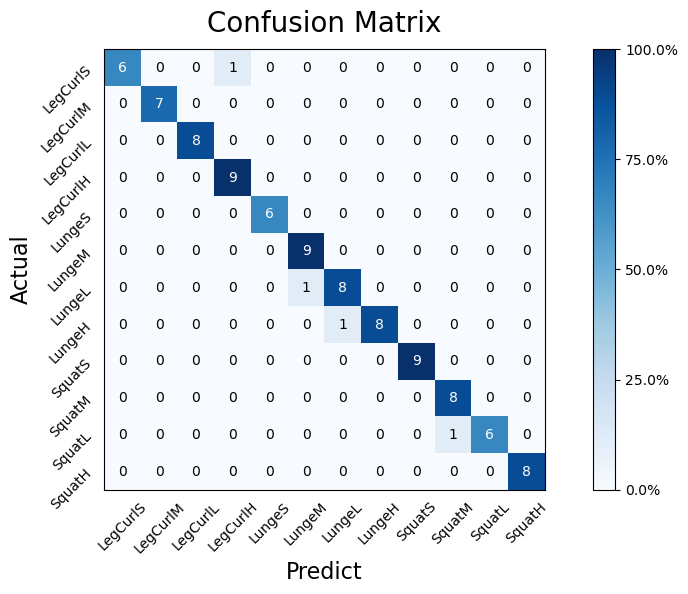

In [140]:
import matplotlib.ticker as ticker
# 绘制混淆矩阵
# class_num = 3
class_num = 12
conf_matrix = best_cm
# conf_matrix = cm

# label_lists = {'L', 'M', 'H'}
# label_lists = {'0', '1', '2'}
# label_lists = {'0', '1', '2', '3', '4', '5'}

# 显示数据
# plt.rc('font',family='Times New Roman',size='12')
# plt.matshow(conf_matrix, cmap=plt.cm.Blues) # 根据最下面的图按自己需求更改颜色
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# 在图中标注数量/概率信息
thresh = conf_matrix.max() / 2	#数值颜色阈值，如果数值超过这个，就颜色加深。

# colorbar设置
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
# cb.set_ticks([0,np.max(conf_matrix)//2//2,np.max(conf_matrix)//2
#               ,(np.max(conf_matrix)+np.max(conf_matrix)//2)//2,np.max(conf_matrix)])
cb.set_ticks([0,np.max(conf_matrix)*0.25,np.max(conf_matrix)*0.5
              ,np.max(conf_matrix)*0.75,np.max(conf_matrix)])
cb.set_ticklabels(['0.0%', '25.0%','50.0%', '75.0%', '100.0%'])


for x in range(class_num):
    for y in range(class_num):
        # 注意这里的matrix[y, x]不是matrix[x, y]
        info = int(conf_matrix[y, x])
        plt.text(x, y, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")

ax = plt.gca()
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.tight_layout()#保证图不重叠
plt.title('Confusion Matrix', fontsize=20, y=1.02)
plt.ylabel('Actual', fontsize=16)
plt.xlabel('Predict', fontsize=16)
plt.yticks(range(class_num), label_list, rotation=45)
plt.xticks(range(class_num), label_list, rotation=45)#X轴字体倾斜45°
plt.show()
plt.savefig('cm.png', bbox_inches='tight')
plt.close()

In [126]:
# best_cm result
print(classification_report(y_labels, best_preds))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         8
           3       0.82      1.00      0.90         9
           4       0.86      1.00      0.92         6
           5       1.00      0.56      0.71         9
           6       0.69      1.00      0.82         9
           7       1.00      0.89      0.94         9
           8       1.00      0.89      0.94         9
           9       0.89      1.00      0.94         8
          10       1.00      0.86      0.92         7
          11       0.89      1.00      0.94         8

    accuracy                           0.91        96
   macro avg       0.93      0.91      0.91        96
weighted avg       0.93      0.91      0.90        96



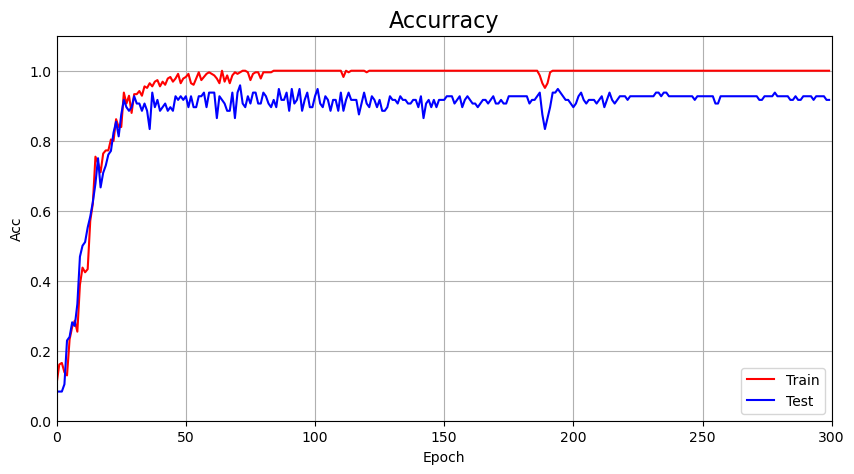

In [141]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.tick_params(axis='y', length=0.1)
plt.ylim(0, 1.1)
plt.xlim(0, epoch_counter)
plt.title('Accurracy', fontsize=16)
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()
plt.savefig(f'acc.png')

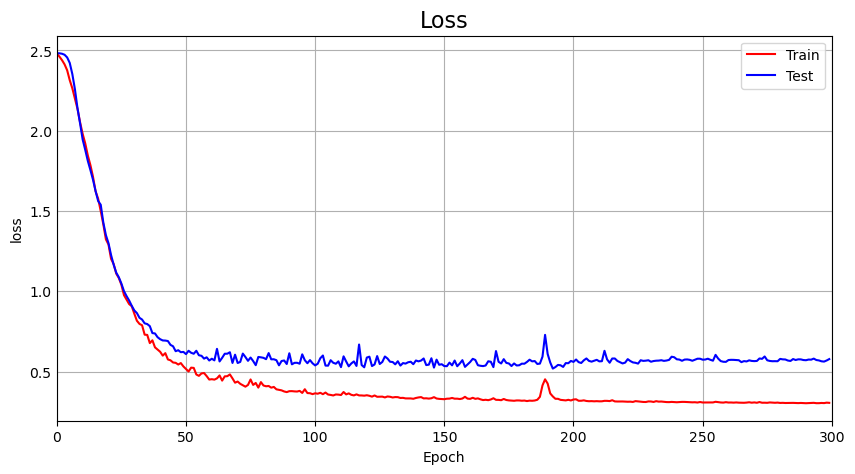

In [142]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.tick_params(axis='y', length=0.2)
# plt.ylim(0, 1.1)
plt.xlim(0, epoch_counter)
plt.title('Loss', fontsize=16)
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Test')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.savefig(f'loss.png')

In [109]:
import torch
cat_dict = torch.load('/kaggle/working/model.pt')
for k, v in enumerate(cat_dict):  # k 参数名 v 对应参数值
    print(k, v)
# print(cat_dict['optimizer'])

0 model
1 optimizer
2 epoch


In [100]:
import torch
torch.cuda.empty_cache()